In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from torch.utils.data import DataLoader
import torch
from torch.autograd import Variable
from faster_rcnn.utils.cython_bbox import bbox_overlaps
from pycrayon import CrayonClient

import cPickle
from torch.optim import SGD, RMSprop, Adam
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from faster_rcnn.utils.datasets.adapter import convert_data
from faster_rcnn.utils.evaluate.metter import AverageMeter
from faster_rcnn.utils.display.images import imshow, result_show
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler

### Đọc dữ liệu từ MS COCO dataset


In [3]:
from faster_rcnn.utils.datasets.adapter import convert_data

In [4]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.datasets.voc.voc import VOCDetection
from torch.utils.data import DataLoader


root = '/data/data'
ds = VOCDetection(root, 'train')
val_ds = VOCDetection(root, 'val')
print(len(ds), len(val_ds))
batch_size = 4

# validation_split = .2
# shuffle_dataset = True
# random_seed= 42

# # Creating data indices for training and validation splits:
# dataset_size = len(ds)
# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))
# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]

# # Creating PT data samplers and loaders:
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=convert_data, num_workers=0, drop_last=True)
val_data_loader = DataLoader(val_ds, batch_size=batch_size, collate_fn=convert_data, num_workers=0, drop_last=True)

(8768, 1927)


In [5]:
train_data_loader.batch_size
print len(train_data_loader)
print len(val_data_loader)

2192
481


[[304.97237569 409.06077348 487.29281768 543.64640884 105.        ]]


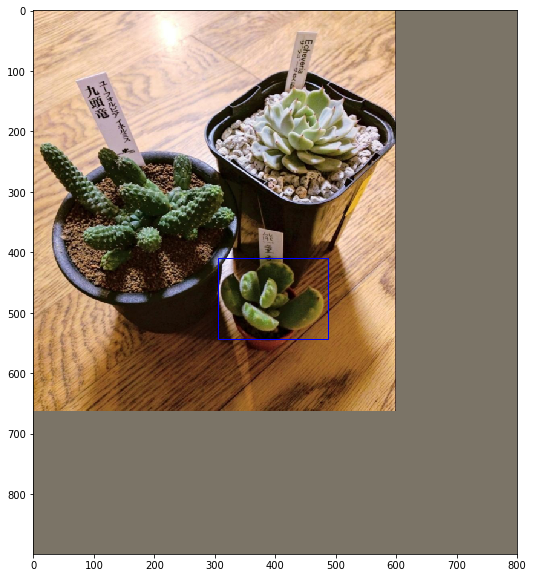

[[ 61.6 166.4 572.  722.4 122. ]]


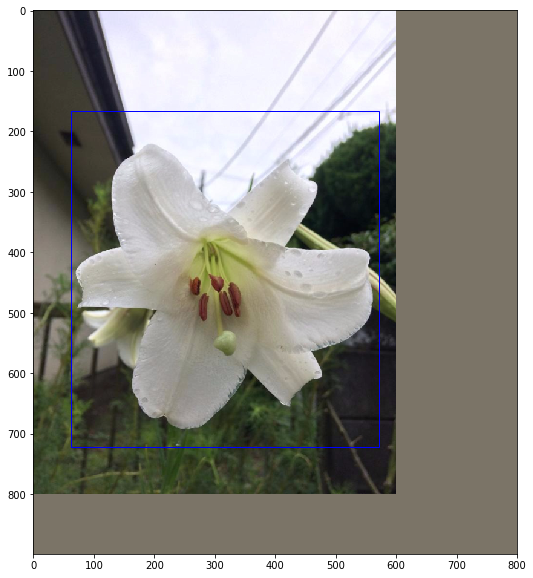

[[123.23838081  62.06896552 494.75262369 747.52623688  38.        ]]


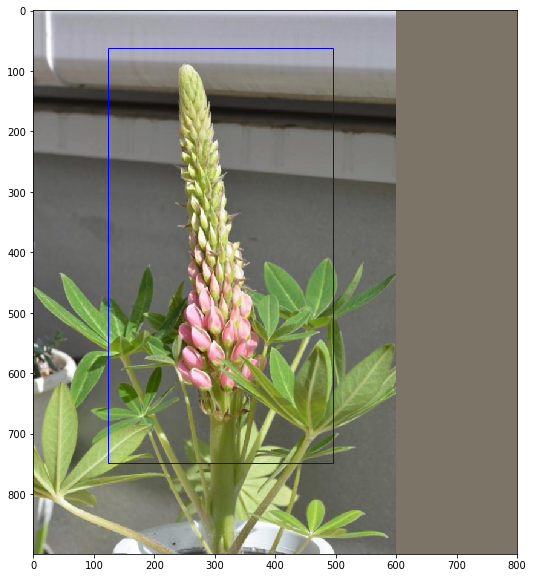

[[247.2 104.8 648.  416.8 134. ]]


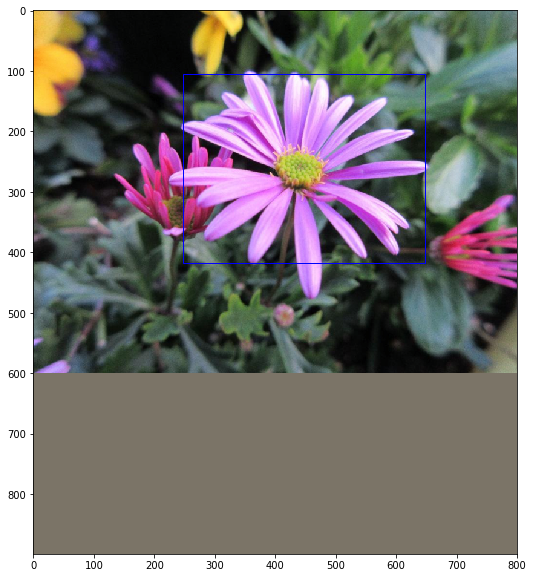

[[ 76.8 465.6 300.  742.4  67. ]
 [343.2 276.  538.4 544.8  67. ]
 [111.2 200.8 368.  531.2  67. ]]


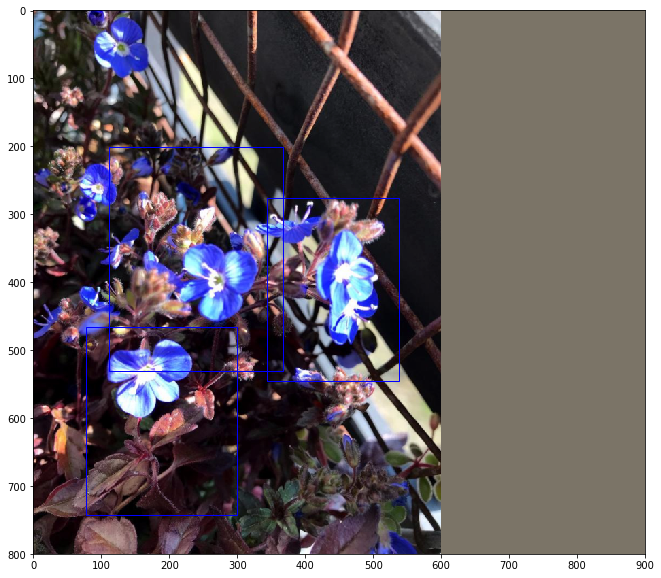

[[  0.   37.6 584.8 730.4  72. ]]


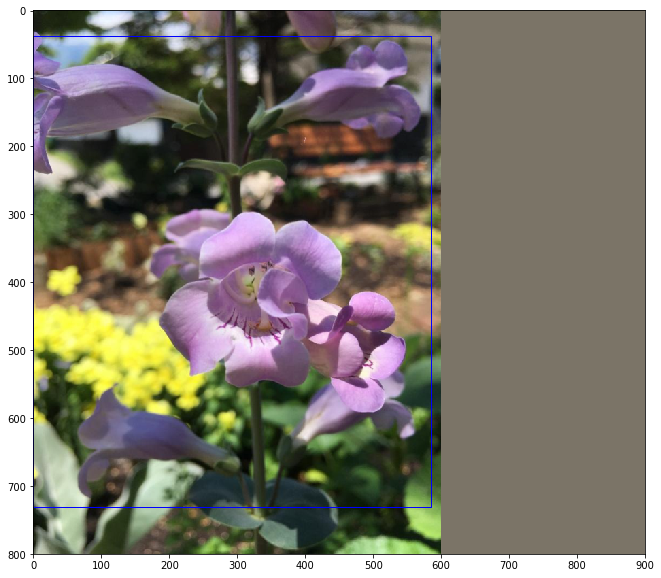

[[ 20.8  72.  174.4 480.   75. ]]


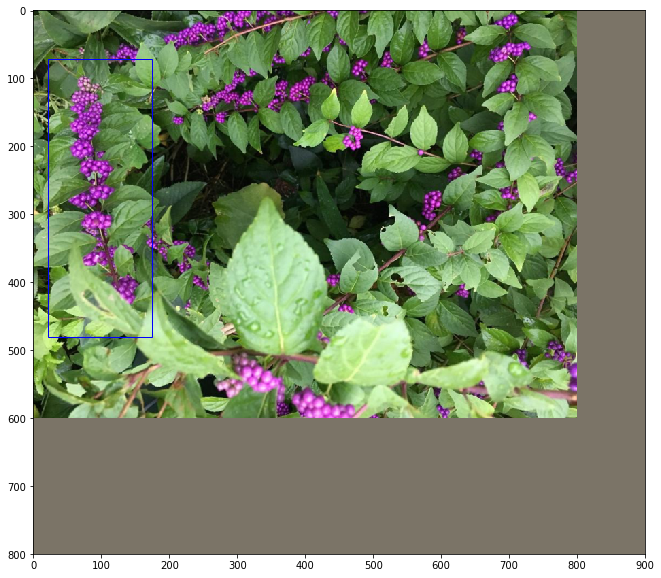

[[105.40540541  17.11711712 809.00900901 600.          74.        ]]


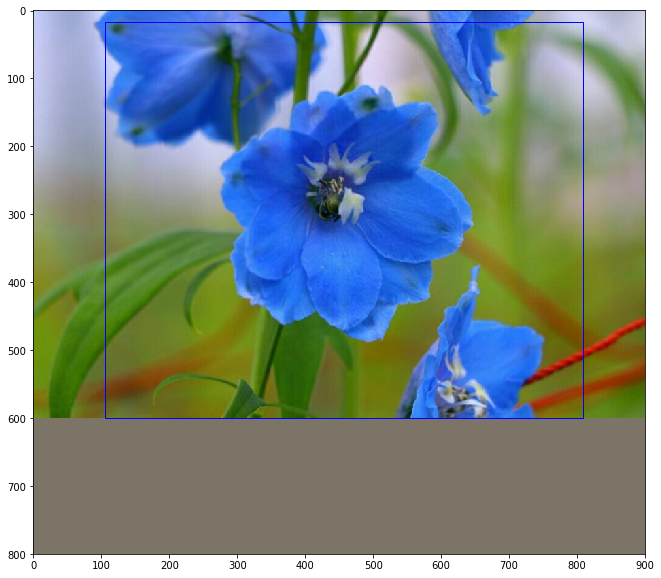

[[138.4  36.8 303.2 243.2 128. ]
 [280.8 191.2 438.4 418.4 128. ]]


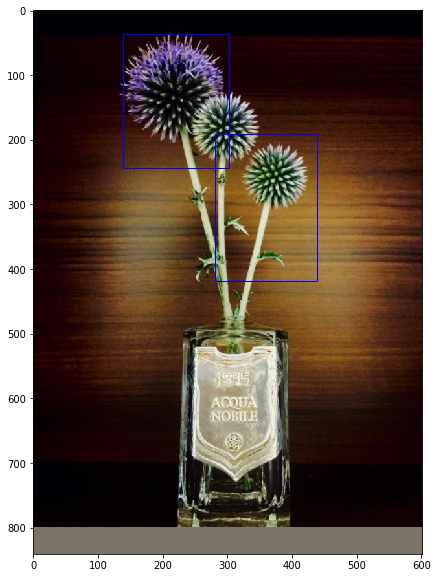

[[100.  360.8 249.6 589.6  67. ]
 [251.2 469.6 458.4 658.4  67. ]]


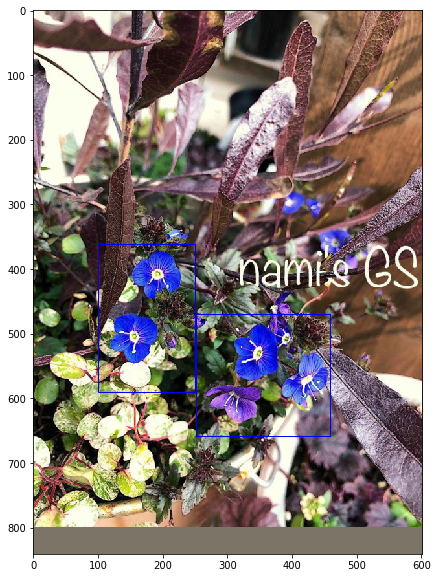

[[367.46987952 169.87951807 572.89156627 372.89156627  34.        ]
 [ 76.5060241  216.86746988 227.71084337 351.20481928  34.        ]]


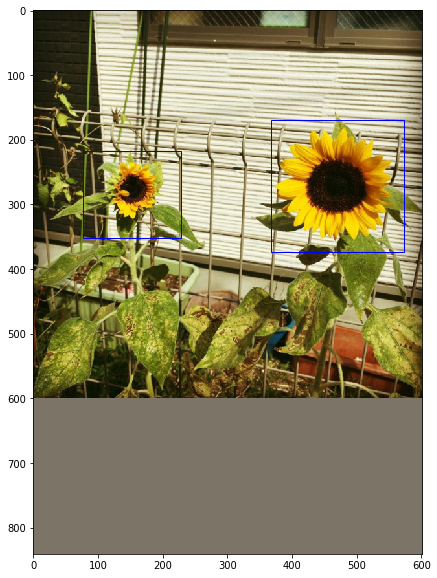

[[ 20.19635344 153.15568022 600.         713.60448808  60.        ]]


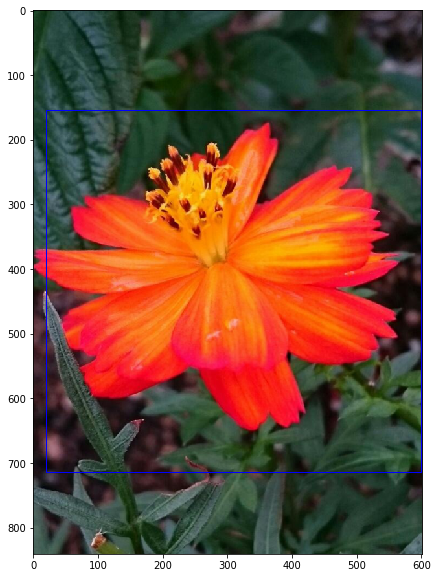

In [6]:
for i, data in enumerate(train_data_loader):
    if not data:
        continue
    if i > 2:
        break
    batch_tensor, im_info, batch_boxes, batch_boxes_index = data
    for k in range(batch_tensor.shape[0]):
        print(batch_boxes[ np.where(batch_boxes_index == k )])
        imshow(batch_tensor[k], predict_boxes=batch_boxes[ np.where(batch_boxes_index == k )])

Thử hiển thị ảnh cùng các bounding boxes

In [7]:
from faster_rcnn.faster_rcnn import FastRCNN


### Tính toán feed-forward


Chúng ta sử dụng một ảnh có kích thước đầu vào là  `(width , height) = (600, 800)`

Input:
    - im_data : 
        kích thước : (batch_size, dim, witdh, height)
    - ground_boxes: 
        kích thước (n, 4)
        

In [8]:
categories = ds.classes
print(categories)

['__background__', u'1701', u'2102', u'657', u'817', u'2149', u'6733', u'1729', u'1009', u'1277', u'2509', u'17387', u'1538', u'1218', u'9893', u'1365', u'1434', u'1457', u'10641', u'2270', u'792', u'1279', u'1220', u'690', u'1243', u'1660', u'755', u'481', u'671', u'397', u'10564', u'1490', u'10576', u'968', u'893', u'440', u'3722', u'29954', u'1247', u'11262', u'2690', u'1271', u'872', u'3478', u'48508', u'1486', u'803', u'1044', u'1619', u'1664', u'1642', u'13373', u'31209', u'1129', u'587', u'2077', u'1058', u'1245', u'788', u'3381', u'10610', u'1799', u'17126', u'5308', u'7710', u'1439', u'1276', u'5563', u'251', u'975', u'808', u'1167', u'1016', u'1593', u'7096', u'1143', u'1907', u'37', u'1077', u'1833', u'770', u'965', u'1950', u'39368', u'5384', u'1842', u'6061', u'822', u'4432', u'2101', u'625', u'853', u'9347', u'984', u'2541', u'449', u'683', u'1205', u'2345', u'1458', u'1217', u'1446', u'834', u'1777', u'1126', u'1862', u'16064', u'6030', u'1970', u'650', u'810', u'68', u'

In [9]:
ds.label_map_dict

{u'1009': 8,
 u'1016': 72,
 u'1044': 47,
 u'10564': 30,
 u'10576': 32,
 u'1058': 56,
 u'10610': 60,
 u'10641': 18,
 u'1077': 78,
 u'1126': 104,
 u'11262': 39,
 u'1129': 53,
 u'1136': 130,
 u'1143': 75,
 u'1163': 140,
 u'1167': 71,
 u'1173': 113,
 u'1203': 122,
 u'1205': 97,
 u'12122': 131,
 u'1217': 100,
 u'1218': 13,
 u'1220': 22,
 u'1227': 126,
 u'1243': 24,
 u'1245': 57,
 u'1247': 38,
 u'1248': 128,
 u'1271': 41,
 u'1276': 66,
 u'1277': 9,
 u'1279': 21,
 u'13373': 51,
 u'1365': 15,
 u'1434': 16,
 u'1439': 65,
 u'1446': 101,
 u'1457': 17,
 u'1458': 99,
 u'146': 112,
 u'1485': 139,
 u'1486': 45,
 u'1490': 31,
 u'1538': 12,
 u'1589': 136,
 u'1593': 73,
 u'16064': 106,
 u'1619': 48,
 u'1642': 50,
 u'1660': 25,
 u'1664': 49,
 u'1675': 135,
 u'1701': 1,
 u'17126': 62,
 u'1729': 7,
 u'17387': 11,
 u'1777': 103,
 u'1799': 61,
 u'1833': 79,
 u'18405': 137,
 u'1842': 85,
 u'1862': 105,
 u'1907': 76,
 u'1950': 82,
 u'1970': 108,
 u'2077': 55,
 u'210': 120,
 u'2101': 89,
 u'2102': 2,
 u'2149': 

In [10]:
net = FastRCNN(categories, debug=False)
net.cuda()
net.train()

FastRCNN(
  (rpn): RPN(
    (features): DataParallel(
      (module): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (15): 

In [11]:
param = filter(lambda x: x.requires_grad, net.parameters())
optimizer = RMSprop(param, lr=1e-5, momentum=0.9, weight_decay=0.00005)
exp_lr_scheduler = StepLR(optimizer, step_size=1000, gamma=0.99)

In [12]:
def train(data_gen ,model, tensorboard_client, metters, optimizer, lr_scheduler, current_epoch=0):
    
    steps_per_epoch = len(data_gen) 
    
    train_loss , cross_entropy_loss , loss_box, rpn_loss_box, rpn_cross_entropy_loss = metters
    for step, blobs in enumerate(data_gen):
        model.train()
        if not blobs:
            continue
        batch_tensor, im_info, batch_boxes, batch_boxes_index = blobs
        cls_prob, bbox_pred, rois, cls_score, target, rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target = model(batch_tensor, im_info, batch_boxes, batch_boxes_index)
        rpn_cross_entropy, rpn_bbox_loss = model.rpn.build_loss(rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target)
        cross_entropy, bbox_loss = model.build_loss(cls_score, bbox_pred, target)
        loss = rpn_cross_entropy + rpn_bbox_loss * 10 + cross_entropy + bbox_loss * 10
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        train_loss.update(loss.item())   
        cross_entropy_loss.update(cross_entropy.item())
        loss_box.update(bbox_loss.item())
        rpn_loss_box.update(rpn_bbox_loss.item())
        rpn_cross_entropy_loss.update(rpn_cross_entropy.item())

        current_step = current_epoch * steps_per_epoch + step
        if step % 100 == 1:
            log_text = 'epoch: %d : step %d,  loss: %.4f at %s' % (
                current_epoch + 1, step , train_loss.avg, datetime.now().strftime('%m/%d_%H:%M'))
            print(log_text)

        if step % 100 == 0:
            tensorboard_client.add_scalar_value('train_loss', train_loss.avg, step=current_step)
            tensorboard_client.add_scalar_value('cross_entropy', cross_entropy_loss.avg, step=current_step)
            tensorboard_client.add_scalar_value('loss_box', loss_box.avg, step=current_step)
            tensorboard_client.add_scalar_value('rpn_cross_entropy_loss', rpn_cross_entropy_loss.avg, step=current_step)
            tensorboard_client.add_scalar_value('rpn_loss_box', rpn_loss_box.avg, step=current_step)


        del loss, rpn_cross_entropy , rpn_bbox_loss , cross_entropy , bbox_loss, cls_prob, bbox_pred, rois, cls_score, target, rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target

In [13]:
def validate(validate_data_gen ,model, tensorboard_client, current_epoch):
    
    steps_per_epoch = len(validate_data_gen)
    
    train_loss = AverageMeter()
    
    for step, blobs in enumerate(validate_data_gen):
        with torch.no_grad():
            model.train()
            if not blobs:
                continue
            batch_tensor, im_info, batch_boxes, batch_boxes_index = blobs
            cls_prob, bbox_pred, rois, cls_score, target, rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target = model(batch_tensor, im_info, batch_boxes, batch_boxes_index)
            rpn_cross_entropy, rpn_bbox_loss = model.rpn.build_loss(rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target)
            cross_entropy, bbox_loss = model.build_loss(cls_score, bbox_pred, target)
            loss = rpn_cross_entropy + rpn_bbox_loss * 10 + cross_entropy + bbox_loss * 10

            train_loss.update(loss.item())     

            current_step = current_epoch * steps_per_epoch + step
            if step % 300 == 1:
                log_text = 'epoch: %d : step %d,  val_loss: %.4f at %s' % (
                    current_epoch + 1, step , train_loss.avg, datetime.now().strftime('%m/%d_%H:%M'))
                print(log_text)
        
    tensorboard_client.add_scalar_value('val_loss', train_loss.avg, step=current_epoch)



In [14]:
def training(data, val_data, optimizer, lr_scheduler ,model, epochs=10):
    
    exp_name = datetime.now().strftime('vgg16_%m-%d_%H-%M3')
    cc = CrayonClient(hostname="crayon", port=8889)
    exp = cc.create_experiment(exp_name)
    
    
    train_loss = AverageMeter()
    cross_entropy = AverageMeter()
    loss_box = AverageMeter()
    rpn_loss_box = AverageMeter()
    rpn_cross_entropy = AverageMeter()
    metters = (train_loss , cross_entropy , loss_box, rpn_loss_box, rpn_cross_entropy)

    for epoch in range(epochs):
        train(data ,model, exp, metters, optimizer, lr_scheduler, epoch)
        validate(val_data ,model, exp, epoch)
        torch.save(net.state_dict(), './checkpoints/faster_model_at_%d.pkl' % epoch) 

In [ ]:
training(train_data_loader, val_data_loader ,optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=100)

faster_rcnn/rpn_msr/anchor_target_layer.py:333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  current_batch_boxes = batch_boxes[[batch_boxes_index == i]]
faster_rcnn/rpn_msr/proposal_target_layer.py:75: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  current_gt_boxes = gt_boxes[[gt_boxes_index == i]]
faster_rcnn/faster_rcnn.py:262: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_prob = F.softmax(cls_score)


epoch: 1 : step 1,  loss: 10.4893 at 11/08_07:24
epoch: 1 : step 101,  loss: 4.7278 at 11/08_07:26
epoch: 1 : step 201,  loss: 4.4380 at 11/08_07:28
epoch: 1 : step 301,  loss: 4.2179 at 11/08_07:30
epoch: 1 : step 401,  loss: 4.2038 at 11/08_07:32
epoch: 1 : step 501,  loss: 4.1788 at 11/08_07:34
epoch: 1 : step 601,  loss: 4.1374 at 11/08_07:36
epoch: 1 : step 701,  loss: 4.1044 at 11/08_07:38
epoch: 1 : step 801,  loss: 4.0917 at 11/08_07:40
epoch: 1 : step 901,  loss: 4.0759 at 11/08_07:42
epoch: 1 : step 1001,  loss: 4.0630 at 11/08_07:44
epoch: 1 : step 1101,  loss: 4.0603 at 11/08_07:47
epoch: 1 : step 1201,  loss: 4.0598 at 11/08_07:49
epoch: 1 : step 1301,  loss: 4.0596 at 11/08_07:51
epoch: 1 : step 1401,  loss: 4.0524 at 11/08_07:53
epoch: 1 : step 1501,  loss: 4.0539 at 11/08_07:55
epoch: 1 : step 1601,  loss: 4.0562 at 11/08_07:57
epoch: 1 : step 1701,  loss: 4.0581 at 11/08_07:59
epoch: 1 : step 1801,  loss: 4.0576 at 11/08_08:01
epoch: 1 : step 1901,  loss: 4.0584 at 11/

epoch: 7 : step 1801,  loss: 3.5891 at 11/08_12:59
epoch: 7 : step 1901,  loss: 3.5854 at 11/08_13:01
epoch: 7 : step 2001,  loss: 3.5821 at 11/08_13:03
epoch: 7 : step 2101,  loss: 3.5782 at 11/08_13:05
epoch: 7 : step 1,  val_loss: 3.2991 at 11/08_13:07
epoch: 7 : step 301,  val_loss: 3.0665 at 11/08_13:10
epoch: 8 : step 1,  loss: 3.5748 at 11/08_13:11
epoch: 8 : step 101,  loss: 3.5710 at 11/08_13:13
epoch: 8 : step 201,  loss: 3.5674 at 11/08_13:16
epoch: 8 : step 301,  loss: 3.5632 at 11/08_13:18
epoch: 8 : step 401,  loss: 3.5596 at 11/08_13:20
epoch: 8 : step 501,  loss: 3.5554 at 11/08_13:22
epoch: 8 : step 601,  loss: 3.5523 at 11/08_13:24
epoch: 8 : step 701,  loss: 3.5488 at 11/08_13:26
epoch: 8 : step 801,  loss: 3.5456 at 11/08_13:28
epoch: 8 : step 901,  loss: 3.5424 at 11/08_13:30
epoch: 8 : step 1001,  loss: 3.5387 at 11/08_13:32
epoch: 8 : step 1101,  loss: 3.5354 at 11/08_13:34
epoch: 8 : step 1201,  loss: 3.5315 at 11/08_13:36
epoch: 8 : step 1301,  loss: 3.5284 at 

epoch: 14 : step 1001,  loss: 3.1269 at 11/08_18:28
epoch: 14 : step 1101,  loss: 3.1242 at 11/08_18:30
epoch: 14 : step 1201,  loss: 3.1212 at 11/08_18:32
epoch: 14 : step 1301,  loss: 3.1185 at 11/08_18:34
epoch: 14 : step 1401,  loss: 3.1157 at 11/08_18:36
epoch: 14 : step 1501,  loss: 3.1131 at 11/08_18:38
epoch: 14 : step 1601,  loss: 3.1103 at 11/08_18:40
epoch: 14 : step 1701,  loss: 3.1075 at 11/08_18:42
epoch: 14 : step 1801,  loss: 3.1052 at 11/08_18:44
epoch: 14 : step 1901,  loss: 3.1025 at 11/08_18:46
epoch: 14 : step 2001,  loss: 3.1000 at 11/08_18:48
epoch: 14 : step 2101,  loss: 3.0974 at 11/08_18:50
epoch: 14 : step 1,  val_loss: 2.6832 at 11/08_18:52
epoch: 14 : step 301,  val_loss: 2.2789 at 11/08_18:55
epoch: 15 : step 1,  loss: 3.0951 at 11/08_18:57
epoch: 15 : step 101,  loss: 3.0920 at 11/08_18:59
epoch: 15 : step 201,  loss: 3.0890 at 11/08_19:01
epoch: 15 : step 301,  loss: 3.0859 at 11/08_19:03
epoch: 15 : step 401,  loss: 3.0828 at 11/08_19:05
epoch: 15 : ste

epoch: 21 : step 101,  loss: 2.7479 at 11/08_23:55
epoch: 21 : step 201,  loss: 2.7454 at 11/08_23:57
epoch: 21 : step 301,  loss: 2.7428 at 11/08_23:59
epoch: 21 : step 401,  loss: 2.7404 at 11/09_00:01
epoch: 21 : step 501,  loss: 2.7380 at 11/09_00:03
epoch: 21 : step 601,  loss: 2.7355 at 11/09_00:05
epoch: 21 : step 701,  loss: 2.7330 at 11/09_00:07
epoch: 21 : step 801,  loss: 2.7304 at 11/09_00:09
epoch: 21 : step 901,  loss: 2.7280 at 11/09_00:11
epoch: 21 : step 1001,  loss: 2.7258 at 11/09_00:13
epoch: 21 : step 1101,  loss: 2.7236 at 11/09_00:15
epoch: 21 : step 1201,  loss: 2.7212 at 11/09_00:18
epoch: 21 : step 1301,  loss: 2.7189 at 11/09_00:20
epoch: 21 : step 1401,  loss: 2.7167 at 11/09_00:22
epoch: 21 : step 1501,  loss: 2.7145 at 11/09_00:24
epoch: 21 : step 1601,  loss: 2.7123 at 11/09_00:26
epoch: 21 : step 1701,  loss: 2.7101 at 11/09_00:28
epoch: 21 : step 1801,  loss: 2.7077 at 11/09_00:30
epoch: 21 : step 1901,  loss: 2.7054 at 11/09_00:32
epoch: 21 : step 2001

epoch: 27 : step 1701,  loss: 2.4334 at 11/09_05:24
epoch: 27 : step 1801,  loss: 2.4316 at 11/09_05:26
epoch: 27 : step 1901,  loss: 2.4297 at 11/09_05:28
epoch: 27 : step 2001,  loss: 2.4280 at 11/09_05:30
epoch: 27 : step 2101,  loss: 2.4262 at 11/09_05:32
epoch: 27 : step 1,  val_loss: 1.4457 at 11/09_05:34
epoch: 27 : step 301,  val_loss: 1.8826 at 11/09_05:37
epoch: 28 : step 1,  loss: 2.4245 at 11/09_05:39
epoch: 28 : step 101,  loss: 2.4225 at 11/09_05:41
epoch: 28 : step 201,  loss: 2.4206 at 11/09_05:43
epoch: 28 : step 301,  loss: 2.4188 at 11/09_05:45
epoch: 28 : step 401,  loss: 2.4169 at 11/09_05:47
epoch: 28 : step 501,  loss: 2.4150 at 11/09_05:49
epoch: 28 : step 601,  loss: 2.4131 at 11/09_05:51
epoch: 28 : step 701,  loss: 2.4114 at 11/09_05:53
epoch: 28 : step 801,  loss: 2.4096 at 11/09_05:55
epoch: 28 : step 901,  loss: 2.4078 at 11/09_05:57
epoch: 28 : step 1001,  loss: 2.4059 at 11/09_05:59
epoch: 28 : step 1101,  loss: 2.4041 at 11/09_06:01
epoch: 28 : step 120

In [16]:
torch.save(net.state_dict(), './checkpoints/faster_model.pkl') 

In [17]:
import torch
import gc
for obj in gc.get_objects():
    if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
        print(type(obj), obj.size())

(<class 'torch.Tensor'>, torch.Size([4, 3, 841, 602]))
(<class 'torch.Tensor'>, torch.Size([4, 3, 800, 800]))
(<class 'torch.Tensor'>, torch.Size([1]))
(<class 'torch.Tensor'>, torch.Size([1]))
(<class 'torch.Tensor'>, torch.Size([1]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([512]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([512, 512, 3, 3]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([24]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([24, 512, 1, 1]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([48]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([48, 512, 1, 1]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([4096]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([4096, 25088]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([4096]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([4096, 4096]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([564]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([564, 

In [18]:
gc.collect()

818

In [ ]:
# net.load_state_dict(torch.load('./checkpoints/faster_model_at_18.pkl'))

In [ ]:
data = pd.read_csv("./test_im/data.csv")

In [ ]:
name = dict(zip(data.id, data.name))

(u'787', (55.677284111818096, 0.0), (657.289237142063, 496.14992164830767))
(u'824', (328.9919922776015, 332.4522759901005), (441.63415117813213, 483.7613568578423))


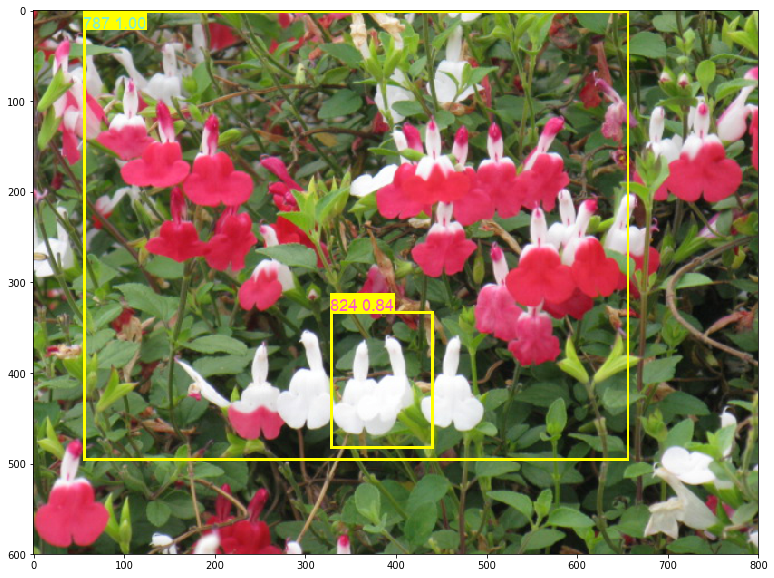

In [48]:
with torch.no_grad():
    result =  net.detect("./test_im/657-2.jpg", thr=0.5)
    if result:
        pred_boxes, scores, classes, rois, im_data = result
        if(len(pred_boxes)):
            result_show(im_data[0], pred_boxes, classes, scores)